## Import libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses, optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import fashion_mnist

## Load data

In [2]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype("float32") / x_train.max() # Normalizaion(0, 1)
x_test = x_test.astype("float32") / x_test.max()
print(x_train.shape)
print(x_test.shape)

4423680/4422102 [==============================] - 0s 0us/step
(60000, 28, 28)
(10000, 28, 28)


## Crate Decoder and Encoder

In [3]:
latent_dim = 64

class Encoder(Model):
    '''
    Encoder class, get only dimension of laten layer.
    '''
    
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.flatten = layers.Flatten()
        self.encod = layers.Dense(latent_dim, activation='relu')
        
    def call(self, x):
        x = self.flatten(x)
        return self.encod(x)

    
class Decoder(Model):
    '''
    Decoder class.
    '''
    
    def __init__(self):
        super(Decoder, self).__init__()
        self.decod = layers.Dense(28*28, activation='sigmoid')
        self.reshape = layers.Reshape((28, 28))
        
    def call(self, x):
        x = self.decod(x)
        return self.reshape(x)

## Create model

In [4]:
class Autoencoder(Model):
    '''
    Autoncoder class, get only dimension of laten layer
    '''
    
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder()
        
    def call(self, x):
        x = self.encoder(x)
        return self.decoder(x)

In [5]:
autoencoder = Autoencoder(latent_dim)#

## Create loss with Kullback-Leibler divergence

In [6]:
rho = 0.05

class loss_with_KLD(losses.Loss):
    '''
    Class with Kullback-Leibler divergence added in loss function.
    
    Arguments:
        rho = constant float
    '''
    def __init__(self, rho):
        super(loss_with_KLD, self).__init__()
        self.rho = rho
        self.kl = losses.KLDivergence()
        self.mse = losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM)
        
    def call(self, y_true, y_pred):
        mse = self.mse(y_true, y_pred)
        kl = self.kl(self.rho, y_pred)
        return mse + kl

## Compile

In [7]:
autoencoder.compile(optimizer='adam', loss=loss_with_KLD(rho))

## Fit model

In [8]:
autoencoder.fit(x_train, x_train,
               epochs=10,
               shuffle=True,
               validation_data=(x_test, x_test))

Epoch 1/10
1875/1875 [==============================] - 6s 3ms/step - loss: 34.3079 - val_loss: 10.3437
Epoch 2/10
1875/1875 [==============================] - 5s 3ms/step - loss: 9.5701 - val_loss: 8.2686
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 8.0502 - val_loss: 7.6899
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 7.5377 - val_loss: 7.4723
Epoch 5/10
1875/1875 [==============================] - 5s 3ms/step - loss: 7.3196 - val_loss: 7.2921
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 7.2543 - val_loss: 7.2149
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: 7.1458 - val_loss: 7.2030
Epoch 8/10
1875/1875 [==============================] - 5s 3ms/step - loss: 7.0794 - val_loss: 7.1131
Epoch 9/10
1875/1875 [==============================] - 5s 3ms/step - loss: 7.0520 - val_loss: 7.1074
Epoch 10/10
1875/1875 [==============================] - 5s 3ms/step - loss: 7.0

In [9]:
# Save images after encoding and decoding separately for plotting.
encoded_img = autoencoder.encoder(x_test).numpy()
decoded_img = autoencoder.decoder(encoded_img).numpy()

## Plot images encoder's and decoder's

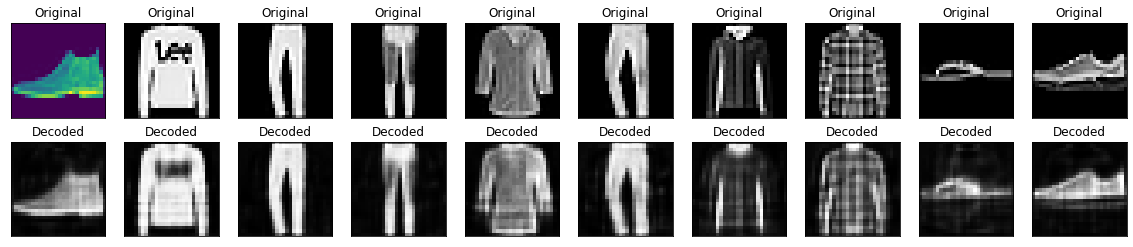

In [10]:
n = 10
plt.figure(figsize=(20,4))
for i in range(10):
    ax = plt.subplot(2, n, i + 1)
    ax.imshow(x_test[i])
    plt.title('Original')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
for i in range(n):
    ax = plt.subplot(2, n, i + 1 + n)
    ax.imshow(decoded_img[i])
    plt.title('Decoded')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

# Image Denoising

In [11]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

In [12]:
x_train = x_train.astype('float32') / x_train.max() # Normalization
x_test = x_test.astype('float32') / x_test.max()

x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

In [13]:
# Add some noise to our images.
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape)
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape)

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

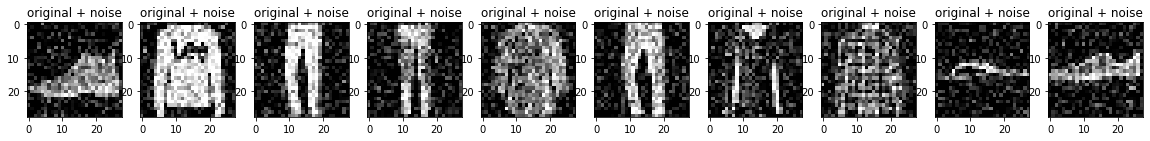

In [14]:
# Show images with nioising.
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

## Create model with convolution layers.

In [15]:
class Denoise(Model):
    '''
    Denoiser with convolutions layers in encoder and decoder.
    '''
    
    def __init__(self):
        super(Denoise, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(28, 28, 1)),
            layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=1),
            layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=1)
        ])
        
        self.decoder = tf.keras.Sequential([
            layers.Conv2DTranspose(8, kernel_size=3, activation='relu', padding='same', strides=1),
            layers.Conv2DTranspose(16, kernel_size=3, activation='relu', padding='same', strides=1),
            layers.Conv2DTranspose(1, kernel_size=(3, 3), activation='sigmoid', padding='same')
        ])
        
    def call(self, x):
        x = self.encoder(x)
        return self.decoder(x)

In [16]:
# Initialize model, loss and optimazer.
conv_autoencoder = Denoise()

loss_fn = losses.MeanSquaredError()
optim = optimizers.Adam()

In [17]:
conv_autoencoder.compile(loss=loss_fn, optimizer=optim)

In [18]:
conv_autoencoder.fit(x_train_noisy, x_train,
               epochs=10,
               shuffle=True,
               validation_data=(x_test_noisy, x_test))

Epoch 1/10
1875/1875 [==============================] - 70s 37ms/step - loss: 0.0244 - val_loss: 0.0065
Epoch 2/10
1875/1875 [==============================] - 70s 37ms/step - loss: 0.0064 - val_loss: 0.0061
Epoch 3/10
1875/1875 [==============================] - 71s 38ms/step - loss: 0.0061 - val_loss: 0.0061
Epoch 4/10
1875/1875 [==============================] - 71s 38ms/step - loss: 0.0059 - val_loss: 0.0058
Epoch 5/10
1875/1875 [==============================] - 77s 41ms/step - loss: 0.0058 - val_loss: 0.0058
Epoch 6/10
1875/1875 [==============================] - 75s 40ms/step - loss: 0.0058 - val_loss: 0.0057
Epoch 7/10
1875/1875 [==============================] - 71s 38ms/step - loss: 0.0057 - val_loss: 0.0057
Epoch 8/10
1875/1875 [==============================] - 71s 38ms/step - loss: 0.0057 - val_loss: 0.0056
Epoch 9/10
1875/1875 [==============================] - 71s 38ms/step - loss: 0.0056 - val_loss: 0.0056
Epoch 10/10
1875/1875 [==============================] - 72s 38m

In [19]:
# Save images after encoding and decoding separately for plotting.
encoded_img = conv_autoencoder.encoder(x_test).numpy()
decoded_img = conv_autoencoder.decoder(encoded_img).numpy()

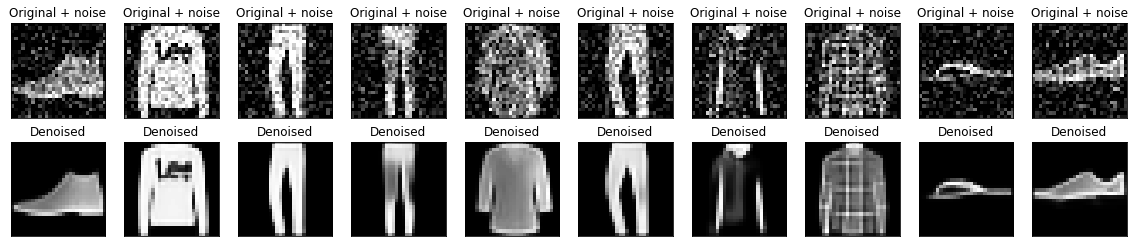

In [20]:
n = 10
plt.figure(figsize=(20,4))
for i in range(10):
    ax = plt.subplot(2, n, i + 1)
    ax.imshow(x_test_noisy[i])
    plt.title('Original + noise')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
for i in range(n):
    ax = plt.subplot(2, n, i + 1 + n)
    ax.imshow(decoded_img[i])
    plt.title('Denoised')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)